In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from multiprocessing import active_children

In [2]:
def load_dataset(train: bool, transform: v2.Compose, download=False) -> Dataset:
    return torchvision.datasets.CIFAR10(root='./data', train=train, download=download, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


basic_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_dataset = load_dataset(train=True, transform=basic_transform)
test_dataset = load_dataset(train=False, transform=basic_transform)
train_loader = DataLoader(train_dataset, batch_size=16)

In [3]:
img_batch, labels = next(iter(train_loader))

In [4]:
img_batch.shape

torch.Size([16, 3, 32, 32])

In [5]:
import matplotlib.pyplot as plt

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2470, 0.2435, 0.2616])

def unnormalize_batch(batch: torch.Tensor):
    unnormalized = batch.permute(0, 2, 3, 1)*std + mean
    return unnormalized.permute(0, 3, 1, 2)
    

def visualize_patches(sequence_of_patches: torch.Tensor, patch_size: int, nrow: int) -> None:
    sequence_length  = len(sequence_of_patches)
    sequence_of_images = sequence_of_patches.reshape(sequence_length, 3,patch_size, patch_size)
    
    sequence_of_images = unnormalize_batch(sequence_of_images)
    image_grid = torchvision.utils.make_grid(sequence_of_images, nrow=nrow, padding=1, pad_value=1)
    
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

In [6]:
import torch.nn as nn


class Patch(nn.Module):

    def __init__(self, patch_size: int, image_size: int, in_channels: int = 3):
        super().__init__()

        if image_size % patch_size:
            raise AssertionError("Image size should be multiple of patch size")

        self.unfold = nn.Unfold((patch_size, patch_size), stride=patch_size)

        self._patches_per_example = image_size*image_size // (patch_size*patch_size)
        self._patch_embedding_size = (patch_size*patch_size*in_channels)

    
    def forward(self, x):
        unfolded = self.unfold(x)
        return unfolded.permute(0, 2, 1)
    
    @property
    def patches_per_example(self):
        return self._patches_per_example
    
    @property
    def patch_embedding_size(self):
        return self._patch_embedding_size

    
patching = Patch(8, 32)
patching.patches_per_example, patching.patch_embedding_size

(16, 192)

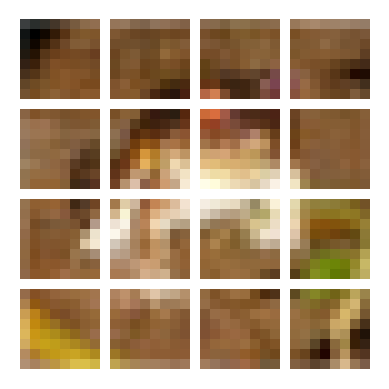

torch.Size([16, 16, 192])

In [7]:
unfolded = patching(img_batch)
visualize_patches(unfolded[0], 8, nrow=4) # visualize fist sequence from batch
unfolded.shape

In [8]:
class Transformer(nn.Module):

    def __init__(
            self,
            input_embedding_size: int,
            hidden_layer_size: int,
            attention_heads: int,
            dropout_rate: float
        ):

        super().__init__()

        self.layer_norm1= nn.LayerNorm(input_embedding_size)
        self.layer_norm2= nn.LayerNorm(input_embedding_size)

        self.linear1 = nn.Linear(input_embedding_size, hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size, input_embedding_size)

        self.attention = nn.MultiheadAttention(input_embedding_size, attention_heads)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x_residual1 = self.layer_norm1(x)

        x_attention, attention_weights = self.attention(x, x, x)
        x_residual2 = x_residual1 + x_attention

        x = self.layer_norm2(x_residual2)

        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x += x_residual2

        return x

class VIT(nn.Module):

    def __init__(
            self, 
            patch_size: int, 
            original_image_size: int,
            embedding_dim: int,
            output_classes: int,
            hidden_layer_dim: int,
            attention_heads: int,
            dropout_rate: float,
            number_of_transformers: int

        ):

        super().__init__()

        self.patching = Patch(patch_size, original_image_size)
        self.linear = nn.Linear(self.patching.patch_embedding_size, embedding_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patching.patches_per_example + 1, embedding_dim), requires_grad=True)

        self.transformers = nn.ModuleList([
            Transformer(
                embedding_dim,
                hidden_layer_dim,
                attention_heads,
                dropout_rate
            ) for _ in range(number_of_transformers)
        ])

        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.linear_decision = nn.Linear(embedding_dim, output_classes)


    def forward(self, x):

        x = self.patching(x)
        x = self.linear(x)

        x = torch.column_stack((self.cls_token.repeat(x.size(0), 1, 1), x))
        x += self.pos_encoding
        x = self.dropout(x)

        for transformer in self.transformers:
            x = transformer(x)

        cls_token = x[:, 0, :]

        final = self.layer_norm(cls_token)
        final = self.linear_decision(final)

        return final

In [9]:
vit = VIT(
    patch_size=8, 
    original_image_size=32, 
    embedding_dim=256, 
    output_classes=10,
    hidden_layer_dim=512,
    attention_heads=8,
    dropout_rate=0.2,
    number_of_transformers=2
)

out = vit(img_batch)
out.shape

torch.Size([16, 10])

In [10]:
sum(p.numel() for p in vit.parameters())

1111306

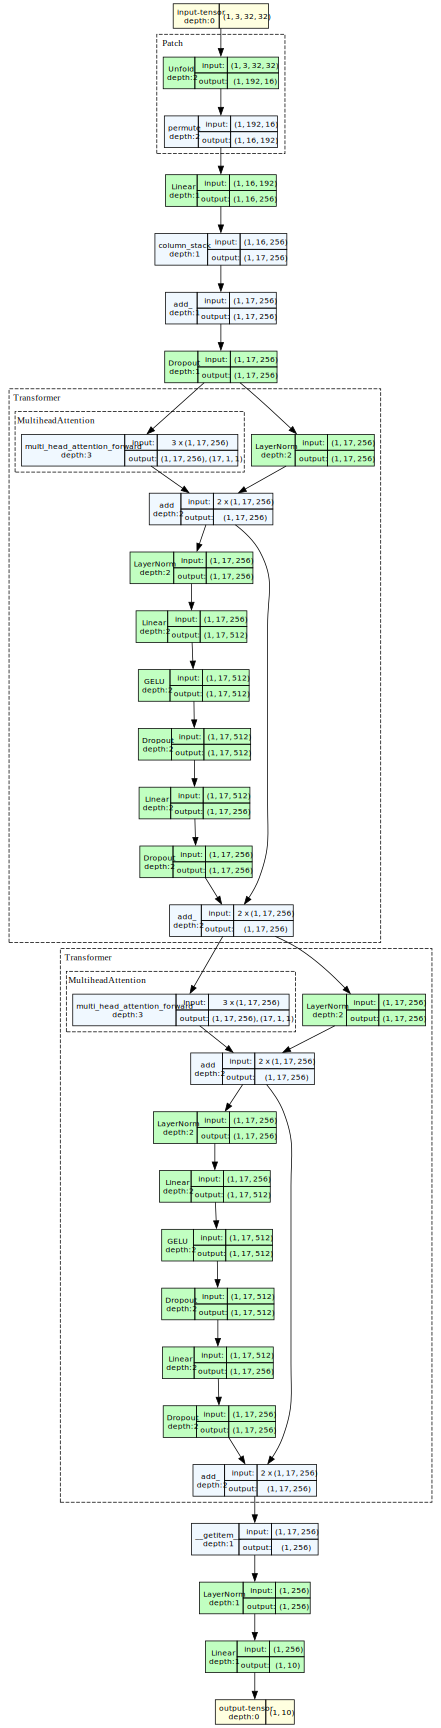

In [11]:
from torchview import draw_graph

model_graph = draw_graph(vit, input_size=(1, 3, 32, 32), expand_nested=True)
model_graph.visual_graph

In [12]:
def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


device = choose_device()
device

'mps'

In [13]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ConstantLR


def compute_test_accuracy(net: nn.Module, data_loader: DataLoader):
    correct_per_class = torch.zeros(10).to(device)
    total_per_class = torch.zeros(10).to(device)

    net = net.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)

            _, predictions = torch.max(outputs, 1)

            correct_labels = labels == predictions
            for i in range(10):
                correct_per_class[i] += (correct_labels & (labels == i)).sum()
                total_per_class[i] += (labels == i).sum()
    
    for i in range(10):
        print(f"{classes[i]}: {(100*correct_per_class[i] / total_per_class[i]):.2f}%")

    print(f"\nTotal accuracy: {(100*correct_per_class.sum() / total_per_class.sum()):.2f}%")

def train_model(
        model: nn.Module, 
        train_dataset: DataLoader, 
        test_dataset: DataLoader,
        max_epochs: int = 160,
        logging_step: int = 1
    ):

    optimizer = AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        number_of_batches = 0

        model.train()

        for inputs, labels in train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
            epoch_loss += batch_loss.item()
            number_of_batches += 1
        
        
        train_loss = epoch_loss / number_of_batches
        
        if epoch % logging_step == 0:
            print(f"Epoch {epoch}")
            print(f"Train average loss: {train_loss:.3f}\n")

        if epoch % 10 == 0:
            compute_test_accuracy(vit, test_dataset)

    return model

In [ ]:
vit = VIT(
    patch_size=16, 
    original_image_size=32,
    embedding_dim=256, 
    output_classes=10,
    hidden_layer_dim=512,
    attention_heads=8,
    dropout_rate=0.2,
    number_of_transformers=6
).to(device)

train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)
test_data_loader = DataLoader(test_dataset, batch_size=128)


In [15]:
vit = train_model(vit, train_data_loader, test_data_loader)

/Users/mnozkiewicz/Studia/semestr7/MRO/.venv/lib/python3.12/site-packages/torch/nn/functional.py:4853: UserWarning: The operator 'aten::im2col' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.im2col(input, _pair(kernel_size), _pair(dilation), _pair(padding), _pair(stride))


Epoch 0
Train average loss: 2.329

plane: 0.00%
car: 0.00%
bird: 0.00%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.00%
ship: 100.00%
truck: 0.00%

Total accuracy: 10.00%
Epoch 1
Train average loss: 2.314

Epoch 2
Train average loss: 2.312

Epoch 3
Train average loss: 2.308

Epoch 4
Train average loss: 2.307

Epoch 5
Train average loss: 2.305

Epoch 6
Train average loss: 2.305

Epoch 7
Train average loss: 2.304

Epoch 8
Train average loss: 2.304

Epoch 9
Train average loss: 2.304

Epoch 10
Train average loss: 2.304

plane: 0.00%
car: 0.00%
bird: 0.00%
cat: 0.00%
deer: 0.00%
dog: 0.00%
frog: 0.00%
horse: 0.00%
ship: 100.00%
truck: 0.00%

Total accuracy: 10.00%
Epoch 11
Train average loss: 2.303

Epoch 12
Train average loss: 2.303

Epoch 13
Train average loss: 2.303

Epoch 14
Train average loss: 2.303

Epoch 15
Train average loss: 2.303

Epoch 16
Train average loss: 2.303

Epoch 17
Train average loss: 2.303

Epoch 18
Train average loss: 2.303

Epoch 19
Train average loss: 2.303

KeyboardInterrupt: 